In [1]:
import sys; sys.path.insert(0,'..')

import os
import torch
import re
from fastai.vision.all import *
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import NoisySpeechDataset
import time
from norse.models.dynamic_model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio
from sampler import SpeechSampler

torchaudio.set_audio_backend('sox_io')

/home/dan/anaconda3/envs/norse/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
batch_size = 64

In [7]:
dataset = NoisySpeechDataset(base_dir='../data', window_size=2)
train_dl, val_dl = SpeechSampler(dataset, .1, batch_size)()
data = DataLoaders(train_dl, val_dl).cuda()

In [8]:
net = Autoencoder(depth=1, kernel_size=31, upsample_type='transpose')

In [5]:
def SDRLoss(output, target):
    #import pdb;pdb.set_trace()
    output = output#.view(-1, 16384)
    target = target#.view(-1, 16384)
    # Check if this is ok
    dot_product = torch.sum(output * target)
    loss = (-1 * dot_product) / (torch.norm(target) * torch.norm(output))
    return loss

In [7]:
def weightedSDR(output, target):
    x = learn.xb[0]
    if x.shape != output.shape:
        output = F.pad(output, (0, 0, x.shape[-1] - output.shape[-1]))
    noise = x - target
    expected_noise = x - output 
    target_norm = torch.norm(target)
    target_norm_sq = target_norm * target_norm
    input_target_norm = torch.norm(x - target)
    input_target_norm_sq = input_target_norm * input_target_norm
    alpha = target_norm_sq / (target_norm_sq + input_target_norm_sq) 
    
    loss = alpha * SDRLoss(output, target) + (1 - alpha) * SDRLoss(noise, expected_noise)
    
    return loss

In [9]:
learn = Learner(data, net, loss_func=nn.MSELoss(), cbs=[CudaCallback])

In [10]:
learn.lr_find()

torch.Size([64, 1, 32000])
torch.Size([64, 16, 16000])
torch.Size([64, 16, 16000])
torch.Size([64, 1, 31999])


/home/dan/anaconda3/envs/norse/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([64, 1, 32000])) that is different to the input size (torch.Size([64, 1, 31999])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (31999) must match the size of tensor b (32000) at non-singleton dimension 2

In [16]:
lr = 1.4e-2
lrs = slice(lr/40,lr/4)
learn.fit_one_cycle(50, lrs)#, wd=1e-2, pct_start=0.2)

epoch,train_loss,valid_loss,time
0,0.157669,0.129417,02:06
1,0.011288,0.005899,01:27
2,0.002261,0.002070,01:23
3,0.001409,0.001354,01:26
4,0.001202,0.001196,01:27
5,0.001127,0.001088,01:23
6,0.001062,0.001057,01:22
7,0.001032,0.001062,01:20
8,0.001030,0.001006,01:24
9,0.001015,0.000986,01:23


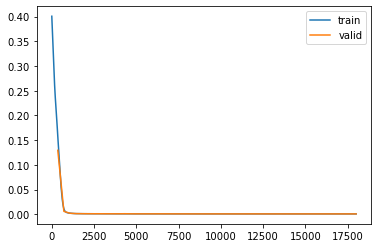

In [17]:
learn.recorder.plot_loss()

In [18]:
learn.save('base_transp_1lay')

Path('models/base_transp_1lay.pth')

In [6]:
learn.load('base_transp_1lay')

In [7]:
from test import test
test(learn.model)

> /home/dan/www/norse/norse/models/dynamic_model.py(141)forward()
    139         x = self.attend(x)
    140         import pdb;pdb.set_trace()
--> 141         for decode in self.decoder:
    142             encoder_output = saved.pop(-1)
    143             layer_in = self.resolve_skip_op(encoder_output, x)



ipdb>  x.shape


torch.Size([1, 16, 18101])


ipdb>  saved


[tensor([[[-0.0070, -0.0146, -0.0158,  ...,  0.0088,  0.0050, -0.0041]]]), tensor([[[ 0.2501,  0.2770,  0.2929,  ...,  0.1203,  0.0797,  0.0396],
         [ 0.2222,  0.5987,  0.6530,  ...,  0.3579,  0.3534,  0.6023],
         [ 0.1000,  0.0628, -0.0038,  ...,  0.1956,  0.1841,  0.0448],
         ...,
         [ 0.1370,  0.1657,  0.1208,  ..., -0.0043,  0.0500,  0.0448],
         [ 0.0330,  0.0149,  0.0103,  ...,  0.2799,  0.2938,  0.3115],
         [ 0.3353,  0.3932,  0.3999,  ...,  0.1628,  0.1487,  0.1194]]])]


ipdb>  len(saved)


2


ipdb>  saved[0]


tensor([[[-0.0070, -0.0146, -0.0158,  ...,  0.0088,  0.0050, -0.0041]]])


ipdb>  saved[0].shape


torch.Size([1, 1, 36219])


ipdb>  self.decoder[0](saved[1])


tensor([[[-0.1589,  0.0429, -0.0916,  ..., -0.1439, -0.3004, -0.2588]]])


ipdb>  self.decoder[0](saved[1]).shape


torch.Size([1, 1, 36218])


ipdb>  q


BdbQuit: 

In [9]:
learn.model

Autoencoder(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 16, kernel_size=(32,), stride=(2,), padding=(7,), bias=False, padding_mode=reflect)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
  )
  (decoder): ModuleList(
    (0): Sequential(
      (0): ConvTranspose1d(16, 1, kernel_size=(32,), stride=(2,), padding=(7,), bias=False)
    )
  )
  (attention): Sequential(
    (0): Conv1d(16, 128, kernel_size=(1,), stride=(1,), bias=False)
    (1): GELU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(128, 16, kernel_size=(1,), stride=(1,))
    (4): Softmax(dim=1)
  )
  (resolver): Sequential(
    (0): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (1): Tanh()
  )
)